# Classification

In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.utils import class_weight 

#### Choose one of the models

In [3]:
isVGG16=False
isInceptionV3=False
isResNet50=False
isXception=False
isDenseNet121=False
isInceptionResNetV2=False
isEfficientNet0=True

In [4]:
if isVGG16==True:             ffilename = 'features_patches_VGG16.npz'
if isInceptionV3==True:       ffilename = 'features_patches_InceptionV3.npz'
if isResNet50==True:          ffilename = 'features_patches_ResNet50.npz'
if isXception==True:          ffilename = 'features_patches_Xception.npz'
if isDenseNet121==True:       ffilename = 'features_patches_DenseNet121.npz'
if isInceptionResNetV2==True: ffilename = 'features_patches_InceptionResNetV2.npz'
if isEfficientNet0==True:     ffilename = 'features_patches_EfficientNetB0.npz'

In [5]:
with np.load(os.path.join('data', 'HLfeatures', ffilename)) as features_npz:
    features_dict = dict(features_npz)

nf = features_dict['arr_0'].shape[1] - 2
features = features_dict['arr_0'][:,:nf].astype(float)
labs = features_dict['arr_0'][:,nf].astype(int)
fns = features_dict['arr_0'][:,-1]
print('Shape of features:', features.shape, '\nShape of labs:', labs.shape, '\nShape of filenames:', fns.shape)

Shape of features: (7980, 1280) 
Shape of labs: (7980,) 
Shape of filenames: (7980,)


In [6]:
print('dtype of features:', features.dtype, '\ndtype of labels:  ', labs.dtype)

dtype of features: float64 
dtype of labels:   int64


In [7]:
class_names = ['adenosis',
            'ductal_carcinoma',
            'fibroadenoma',
            'lobular_carcinoma',
            'mucinous_carcinoma',
            'papillary_carcinoma',
            'phyllodes_tumor',
            'tubular_adenoma']

#### Split in train (80%), validation (10%), and test (10%) data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Split into train/rest sets
X_tr, X_, y_tr, y_, fn_tr, fn_ = train_test_split(
    features, labs, fns,
    test_size=0.2, random_state=0)

# Split into valid/test sets
X_val, X_te, y_val, y_te, fn_val, fn_te = train_test_split(
    X_, y_, fn_, 
    test_size=0.5, random_state=0)

print('train X:', X_tr.shape, '\n      y:', y_tr.shape)
print('valid X:', X_val.shape, '\n      y:', y_val.shape)
print('test  X:', X_te.shape, '\n      y:', y_te.shape)

train X: (6384, 1280) 
      y: (6384,)
valid X: (798, 1280) 
      y: (798,)
test  X: (798, 1280) 
      y: (798,)


#### Proportion of numbers per class

In [10]:
def get_counts(y):
    labs_num = pd.DataFrame(y)[0]
    labs_num_prop = labs_num.value_counts(normalize=True).sort_index()
    labs_num_prop = np.round(labs_num_prop*100, 1)
    labs_num_count = labs_num.value_counts().sort_index()
    return(labs_num_count, labs_num_prop)

In [11]:
count_tr, prop_tr   = get_counts(y_tr)
count_val, prop_val = get_counts(y_val)
count_te, prop_te   = get_counts(y_te)

class_df = pd.DataFrame({'count train': count_tr, 'count validation': count_val, 'count test': count_te,
                         'proportion train (%)': prop_tr, 'proportion validation (%)': prop_val,'proportion test (%)': prop_te,})
class_df.index = class_names
class_df

,count train,count validation,count test,proportion train (%),proportion validation (%),proportion test (%)
adenosis,378,35,43,5.9,4.4,5.4
ductal_carcinoma,2790,334,332,43.7,41.9,41.6
fibroadenoma,808,105,99,12.7,13.2,12.4
lobular_carcinoma,505,62,57,7.9,7.8,7.1
mucinous_carcinoma,635,84,101,9.9,10.5,12.7
papillary_carcinoma,451,75,54,7.1,9.4,6.8
phyllodes_tumor,354,42,40,5.5,5.3,5.0
tubular_adenoma,463,61,72,7.3,7.6,9.0


#### Compute class weights

In [12]:
# https://stackoverflow.com/a/67678520
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr), 
    y=y_tr)

train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 2.111111111111111,
 1: 0.2860215053763441,
 2: 0.9876237623762376,
 3: 1.5801980198019803,
 4: 1.2566929133858267,
 5: 1.76940133037694,
 6: 2.2542372881355934,
 7: 1.7235421166306695}

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(solver='liblinear',  multi_class='auto', class_weight=train_class_weights))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.788


### 1. Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

#### Create and fit random forest estimator

In [22]:
# Create random forest estimator
rf_10 = RandomForestClassifier(
    n_estimators=10, max_depth=None, random_state=0)

# Fit estimator
rf_10.fit(X_tr, y_tr);

#### Create and fit a large random forest estimator

In [23]:
# Create a large random forest estimator
rf_200 = RandomForestClassifier(
    n_estimators=200, max_depth=None, random_state=0)

# Fit estimator
rf_200.fit(X_tr, y_tr);

#### Mean validation scores

In [24]:
# Mean test score of a single decision tree (max depth)
rf_10_scores = cross_validate(rf_10, X_val, y_val, cv=10)
print('Decision tree - mean validation: {:.3f}'.format(
    np.mean(rf_10_scores['test_score'])))

# Mean test score of a random forest (200x, max depth)
rf_200_scores = cross_validate(rf_200, X_val, y_val, cv=10)
print('Random forest - mean validation: {:.3f}'.format(
    np.mean(rf_200_scores['test_score'])))

/usr/local/Caskroom/miniconda/base/envs/my-exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Decision tree - mean validation: 0.290


/usr/local/Caskroom/miniconda/base/envs/my-exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Random forest - mean validation: 0.450


### 2. SVC with Linear and RBF Kernel

#### Create and fit SVM with linear kernel

In [15]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [16]:
# Create SVM with linear kernel
linear_svc = LinearSVC()

# Fit estimator
linear_svc.fit(X_tr, y_tr)

# Accuracy
print('SVM (linear kernel) validation accuracy: {:.3f}'.format(linear_svc.score(X_val, y_val)))

SVM (linear kernel) validation accuracy: 0.531


/usr/local/Caskroom/miniconda/base/envs/my-exts-ml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Create and fit SVM with RBF kernel

In [17]:
# Create SVM with RBF kernel
rbf_svc_c1 = SVC(kernel='rbf', C=1, gamma='auto')

# Fit estimator
rbf_svc_c1.fit(X_tr, y_tr)

# Accuracy
print('SVM (RBF kernel) validation accuracy: {:.3f}'.format(rbf_svc_c1.score(X_val, y_val)))

SVM (RBF kernel) validation accuracy: 0.594


### 3. Compute Test Accuracy and Save to File

In [28]:
accuracy = rf_200.score(X_te, y_te)
print('Test accuracy: {:.3f}'.format(accuracy))
#df = pd.DataFrame({'model': 'random forest', 'test_accuracy': accuracy}, index=[0])
#df.to_csv('testacc.txt', mode='a', header=False)

Test accuracy: 0.519


In [29]:
accuracy = linear_svc.score(X_te, y_te)
print('Test accuracy: {:.3f}'.format(accuracy))
#df = pd.DataFrame({'model': 'svm linear', 'test_accuracy': accuracy}, index=[0])
#df.to_csv('testacc.txt', mode='a', header=False)

Test accuracy: 0.577


In [30]:
accuracy = rbf_svc_c1.score(X_te, y_te)
print('Test accuracy: {:.3f}'.format(accuracy))
#df = pd.DataFrame({'model': 'svm rbv', 'test_accuracy': accuracy}, index=[0])
#df.to_csv('testacc.txt', mode='a', header=False)

Test accuracy: 0.385


### 1. One-Layer Dense Network

#### 🔹 Define model

In [14]:
#import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight 

In [15]:
model = Sequential()
model.add(InputLayer(input_shape=(nf,)))
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 10248     
Total params: 10,248
Trainable params: 10,248
Non-trainable params: 0
_________________________________________________________________


2022-02-15 16:51:10.090830: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Define loss function, optimizer, and metrics to track during training

In [16]:
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

#### 🔹 End training when accuracy stops improving (optional)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

#### 🔹 Fit model

In [18]:
#train_class_weights = {str(k):v for k,v in train_class_weights.items()}
#train_class_weights

In [19]:
history = model.fit(
    x=X_tr, y=y_tr,
    validation_data=(X_val, y_val), 
    batch_size=32, 
    epochs=100,
    shuffle=True, # Shuffle training samples
    #callbacks=[early_stopping],
    class_weight=train_class_weights,
)

2022-02-15 16:51:26.901691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 1.8116 - acc: 0.3048 - val_loss: 1.6221 - val_acc: 0.4637
Epoch 2/100
200/200 [==============================] - 0s 1ms/step - loss: 1.4855 - acc: 0.4491 - val_loss: 1.4947 - val_acc: 0.4449
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 1.3432 - acc: 0.4893 - val_loss: 1.3630 - val_acc: 0.5113
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 1.2521 - acc: 0.5179 - val_loss: 1.2801 - val_acc: 0.5627
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 1.1854 - acc: 0.5392 - val_loss: 1.2300 - val_acc: 0.5652
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 1.1354 - acc: 0.5565 - val_loss: 1.1827 - val_acc: 0.5840
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0935 - acc: 0.5752 - val_loss: 1.1426 - val_acc: 0.5952
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - 

#### Plot loss and accuracy values

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_acc(history, fig, axs):
    # Plot accuracy values
    ax1.plot(history.history['loss'], label='train loss')
    ax1.plot(history.history['val_loss'], label='val loss')
    ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_loss'][-3:]) # last three values
    ))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss value')
    ax1.legend()

    # Plot accuracy values
    ax2.plot(history.history['acc'], label='train acc')
    ax2.plot(history.history['val_acc'], label='val acc')
    ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_acc'][-3:]) # last three values
    ))
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    plt.show()

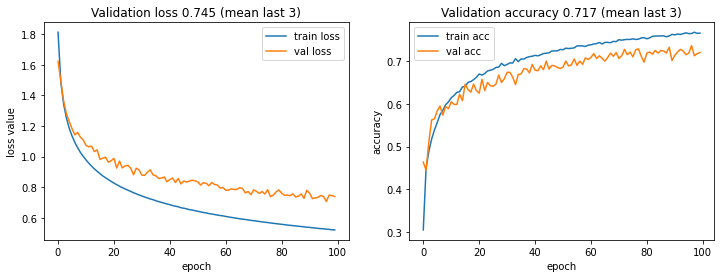

In [21]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acc(history, fig, (ax1, ax2))

### 2. Two-Layer Dense Network

#### 🔹 Define models

In [22]:
model2 = Sequential()
model2.add(Dense(32, activation='relu', input_dim=nf))
model2.add(Dense(8, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 41,256
Trainable params: 41,256
Non-trainable params: 0
_________________________________________________________________


#### Define loss function, optimizer, and metrics to track during training

In [23]:
model2.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

#### 🔹 End training when accuracy stops improving (optional)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

#### 🔹 Fit model

In [25]:
history2 = model2.fit(
    x=X_tr, y=y_tr,
    validation_data=(X_val, y_val), 
    batch_size=32, 
    epochs=100,
    shuffle=True, # Shuffle training samples
    #callbacks=[early_stopping]
)

Epoch 1/100
200/200 [==============================] - 1s 2ms/step - loss: 1.5680 - acc: 0.4781 - val_loss: 1.4395 - val_acc: 0.4875
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 1.3123 - acc: 0.5363 - val_loss: 1.2678 - val_acc: 0.5313
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 1.1768 - acc: 0.5774 - val_loss: 1.1558 - val_acc: 0.5890
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0878 - acc: 0.6134 - val_loss: 1.0907 - val_acc: 0.6078
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0238 - acc: 0.6328 - val_loss: 1.0304 - val_acc: 0.6341
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.9748 - acc: 0.6480 - val_loss: 0.9758 - val_acc: 0.6441
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.9323 - acc: 0.6620 - val_loss: 0.9463 - val_acc: 0.6541
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - 

#### Plot loss and accuracy values

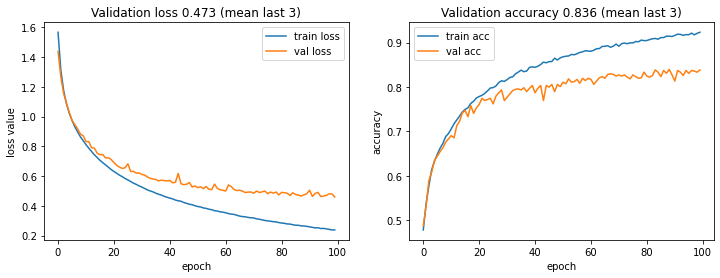

In [26]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acc(history2, fig, (ax1, ax2))

#### Get kernel weights

In [132]:
from matplotlib import image
import matplotlib.pyplot as plt
%matplotlib inline

get kernel weights
https://stackoverflow.com/a/42412124

https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v2/subjects/multilayer-and-convolutional-neural-networks-v2/units/convolutional-neural-networks-v2

https://towardsdatascience.com/dense-or-convolutional-part-2-interpretability-c310a9fd99a5



In [115]:
weights = model2.layers[0].get_weights()[0]
weights.shape

(512, 32)

In [116]:
biases = model2.layers[0].get_weights()[1]
biases.shape

(32,)

(array([2., 2., 6., 8., 5., 5., 2., 1., 0., 1.]),
 array([-0.01611097, -0.01171621, -0.00732146, -0.00292671,  0.00146805,
         0.0058628 ,  0.01025755,  0.01465231,  0.01904706,  0.02344181,
         0.02783656], dtype=float32),
 <BarContainer object of 10 artists>)

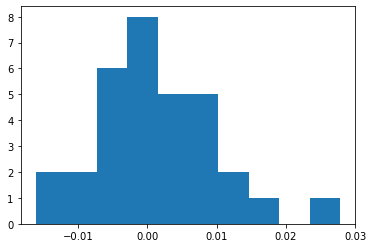

In [117]:
plt.hist(biases)

(array([1., 4., 5., 1., 3., 5., 2., 2., 5., 4.]),
 array([-0.15107107, -0.12371358, -0.09635609, -0.0689986 , -0.0416411 ,
        -0.01428361,  0.01307388,  0.04043137,  0.06778886,  0.09514636,
         0.12250385], dtype=float32),
 <BarContainer object of 10 artists>)

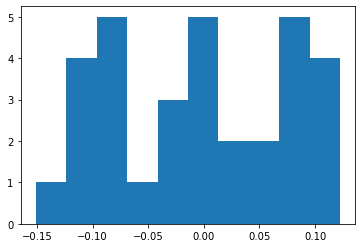

In [118]:
plt.hist(weights[0,:])

Idea: Take all sample from one class and check the weights. Are there ones with exceptionaly many/less weights equal or near zero?

In [119]:
idx = y_tr == 0
X0 = X_tr[idx,:]
X0.shape

(22, 512)

In [120]:
w0 = weights[idx,:]
w0.shape

(22, 32)

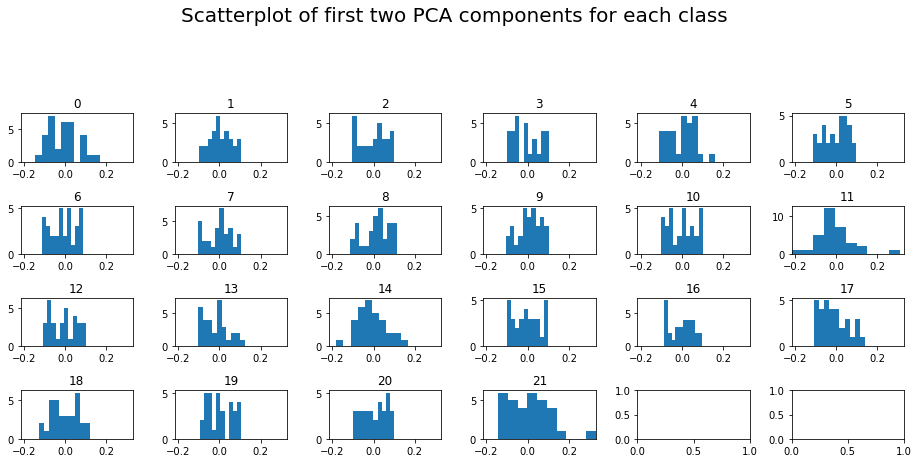

In [121]:
# Plot each class in a separate plot
fig, axs = plt.subplots(4,6, figsize=(13,6))
xmin, xmax = np.min(w0), np.max(w0)
#ymin, ymax = np.min(features_2d[:, 1]), np.max(features_2d[:, 1])

for i in range(22):
    ix, iy = i//6, i%6

    # Plot their components
    axs[ix,iy].hist(
        w0[i,:]
    )
    axs[ix,iy].set_xlim([xmin, xmax])
#    axs[ix,iy].set_ylim([ymin, ymax])
    axs[ix,iy].set_title(i)

fig.suptitle('Scatterplot of first two PCA components for each class\n', fontsize=20, verticalalignment='baseline')
fig.tight_layout()

In [122]:
w0_df = pd.DataFrame(w0)
w0_df.shape

(22, 32)

In [123]:
w0bin = w0_df.applymap(lambda x: x > -0.01 and x < 0.01)
w0bin

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,True,False,True,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
7,True,False,True,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [124]:
w0bin['count0'] = w0bin.apply(np.sum, axis=1)
w0bin.sort_values('count0')

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,count0
18,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
21,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1
2,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,2
16,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,2
4,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,2
11,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,2
20,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,2
14,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,3
12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,3


In [137]:
fn_idx = fn_tr[idx]
fn_sim = fn_idx[18]
fn_sim

'adenosis/SOB_B_A-14-22549AB-40-017__patch_0_0.png'

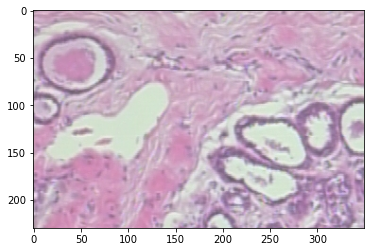

In [140]:
img_data = image.imread('data/breast/40Xpatches/'+fn_sim)
plt.imshow(img_data);

NameError: name 'kernels' is not defined

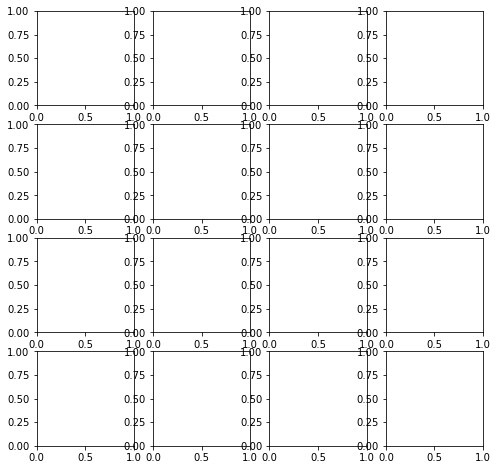

In [33]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the 16 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel
    kernel = kernels[:, :, :, i]

    # Kernels are 5x5x1 (height, width, channels)
    # Remove last dimension
    kernel = kernel[:, :, 0] # (5, 5) kernel

    # Plot kernel with imshow()
    axis.set_title('kernel {}'.format(i+1))
    axis.imshow(kernel, cmap=plt.cm.gray_r)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()
